# Lab Assigment 2 Estimation of Apparent Motion

<p style="text-align:left;">
    José Pedro Cruz
    <span style="float:right;">
        up201504646
    </span>
</p>
<p style="text-align:left;">
    Martinho Figueiredo
    <span style="float:right;">
        up201506179
    </span>
</p>
<p style="text-align:left;">
    Nuno Nascimento
    <span style="float:right;">
        up201907933
    </span>
</p>


[![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/martinhofigueiredo/VC)



## Scheme
```mermaid
flowchart LR
    A[Ingest Footage] -->|mp4 or mpegs| B{Multi Channel?}
    B -->|Yes| C[Split into Channels]
    B -->|No| D[Gray]-->H
    C --> E[R]-->H
    C --> F[G]-->H
    C --> G[B]-->H
    H{Multi Resolution?}-->|Yes|I[n Pyramid DownSampling Average]-->K
    H-->|No|J[One Shot]-->K
    K{algo} -->|HornShunck| M((.flo file))
    K -->|LucasKanade| M
```


## Benchmarking

```mermaid
flowchart LR
    GT[Ground truth] --> B{BenchMark}
    A(Flow Calculated) --> B
    B --> AE(Angular Error and Std Dev)
    B --> EE(Endpoint Error and Std Dev)
```


## Visualization
```mermaid
flowchart LR
    A[import .flo file]-->C{Type}
    C-->VF[Vector Field]
    C-->MF[Middlebury Flow]
    
```

In [1]:
import cv2
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import struct
%matplotlib widget


In [14]:
# Loads a yaml file with the parameters to run the code
def load_config(filename):
    with open(filename, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        config['input_path']= os.getcwd()+config['input_path']
        print(config)
    return config

In [3]:
# Find all jpgs and pngs in a folder and returns a list of their respective path 
def get_frame_paths(folder_path):
    frame_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            frame_path = os.path.join(folder_path, filename)
            frame_paths.append(frame_path)
    frame_paths.sort()
    print(frame_paths)
    return frame_paths

In [15]:
# Checks if the inut file is a directory and if it is it will try and get the frames inside the folder
# it will check if it is and mp4 and if it is it will read it and create a list of frames
def get_input_frames(input_path):
    frames = []
    if os.path.isdir(input_path):
        frame_paths = get_frame_paths(input_path)
        print(f"{frame_paths}")
        frames = [cv2.imread(frame_path) for frame_path in frame_paths]
    else :
        if input_path.endswith('.mp4'):
            cap = cv2.VideoCapture(total_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            cap.release()
    return frames

In [25]:
def write_flow(filename, flow):
    height, width = flow.shape[:2]
    with open(filename, 'wb') as f:
        f.write(struct.pack('f', width))
        f.write(struct.pack('f', height))
        f.write(flow.astype(np.float32).tobytes())
  
def read_flow(filename):
     with open(filename, 'rb') as f:
            magic = np.fromfile(f, np.float32, count=1)
            if 202021.25 != magic:
                print('Magic number incorrect. Invalid .flo file')
            else:
                w = np.fromfile(f, np.int32, count=1)[0]
                h = np.fromfile(f, np.int32, count=1)[0]
                print('Reading %d x %d flo file' % (w, h))
                data = np.fromfile(f, np.float32, count=2*w*h)
                # Reshape data into 3D array (columns, rows, bands)
                flow = np.resize(data, (h, w, 2))

    return flow

def compute_angular_error(flow_gt, flow_est):
    angles_gt = np.arctan2(flow_gt[:, :, 1], flow_gt[:, :, 0])
    angles_est = np.arctan2(flow_est[:, :, 1], flow_est[:, :, 0])
    error = (np.sum((angles_gt - angles_est) ** 2, axis=2))
    return np.mean(error)

def compute_endpoint_error(flow_gt, flow_est):
    error = np.sqrt(np.sum((flow_gt - flow_est) ** 2, axis=2))
    return np.mean(error)

def compare_flow_files(file_gt, file_est):
    flow_gt = read_flow(file_gt)
    flow_est = read_flow(file_est)

    error_endpoint = compute_endpoint_error(flow_gt, flow_est)
    error_angular = compute_angular_error(flow_gt, flow_est)

    return error_endpoint, error_angular

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 21)

# Lucas-Kanade

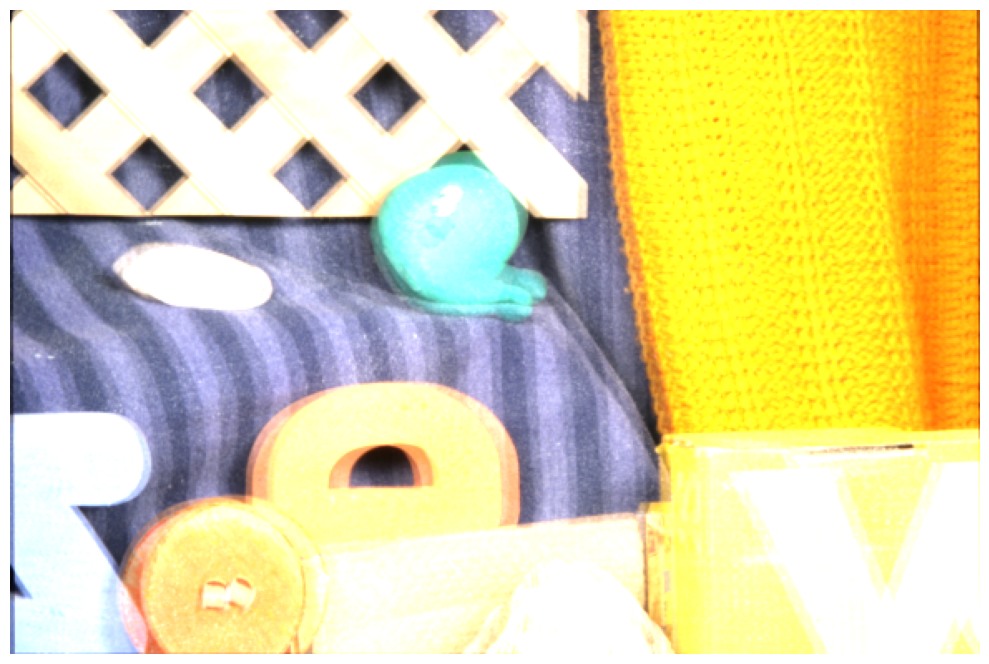

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.

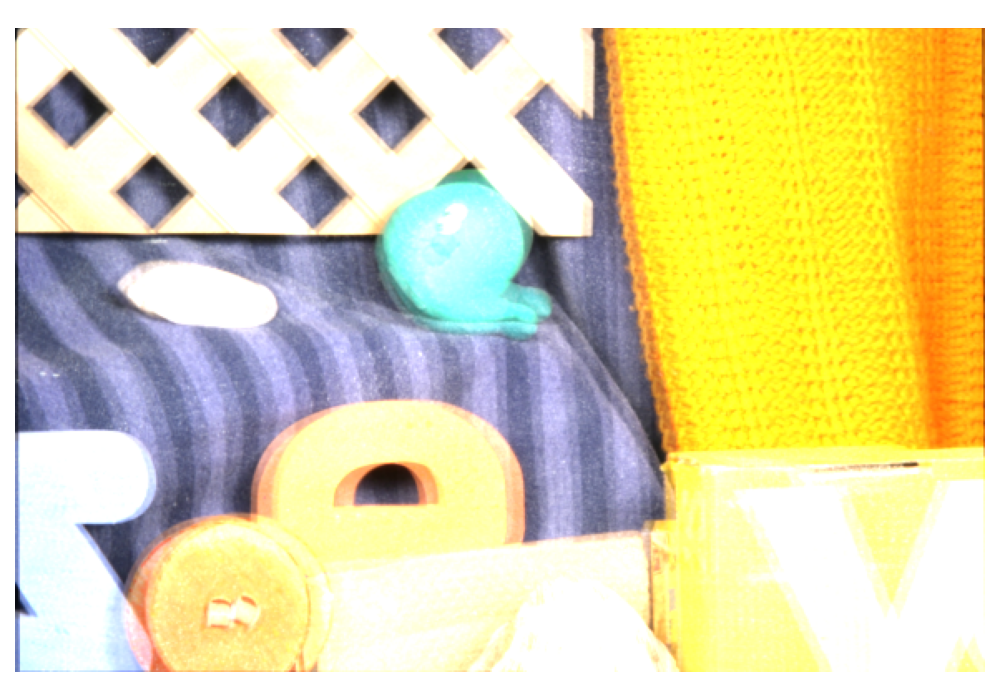

In [26]:
print(f"Loading File \'config_LK.yml\'")

config = load_config('config_LK.yml')

input_path = config['input_path']

print(input_path)
frames = get_input_frames(input_path)


feature_params = dict(
    maxCorners=config['max_corners'],
    qualityLevel=config['quality_level'],
    minDistance=config['min_distance'],
    blockSize=config['block_size']
)
lk_params = dict(
    winSize=(config['window_size'], config['window_size']),
    maxLevel=config['max_level'],
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, config['max_iterations'], config['epsilon'])
)

prev_frame = frames[0]
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_corners = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
prev_roi = cv2.boundingRect(prev_corners)

flow_list = []  #List to store optical flow vectors

mask = np.zeros_like(prev_frame)

fig, ax = plt.subplots(figsize=(10, 7))

for curr_frame in frames[1:]:
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

    curr_corners, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_corners, None, **lk_params)

    good_prev_corners = prev_corners[status == 1]
    good_curr_corners = curr_corners[status == 1]

    flow = good_curr_corners - good_prev_corners # Calculate optical flow vectores
    
    flow_list.append(flow)

    M, _ = cv2.findHomography(good_prev_corners, good_curr_corners, cv2.RANSAC, config['ransac_threshold'])

    warped_roi = cv2.warpPerspective(prev_frame, M, (curr_frame.shape[1], curr_frame.shape[0]))
    warped_mask = cv2.warpPerspective(mask, M, (curr_frame.shape[1], curr_frame.shape[0]))

    output = curr_frame.copy()
    output[warped_mask != 0] = 0
    output = cv2.add(output, warped_roi)

    ax.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    plt.tight_layout()
    clear_output(wait=True)
    display(fig)

    prev_gray = curr_gray.copy()
    prev_corners = good_curr_corners.reshape(-1, 1, 2)
    prev_roi = cv2.boundingRect(prev_corners)
flow_array = np.array(flow_list)

output_file = 'Optical_flow_LS.flo'
write_flow(output_file,flow_array)
cv2.destroyAllWindows()


# Horn-Shunchk

In [ ]:
import cv2
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets import Image
from io import BytesIO
import PIL.Image

def display_image(image):
    # Convert the OpenCV image to a PIL image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = PIL.Image.fromarray(image)
    
    # Display the image using the Jupyter inline magic
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    display(Image(data=buffered.getvalue()))


# Load the tuning parameters from the config file
with open('config_HS.yml', 'r') as f:
    config = yaml.safe_load(f)

# Load the input frames
input_path = os.getcwd()+config['input_path']
input_frames = get_input_frames(input_path)

# Initialize the flow field for the first frame with zeros
prev_frame = input_frames[0]
flow = np.zeros((prev_frame.shape[0], prev_frame.shape[1], 2), dtype=np.float32)

# Set the Horn-Schunck parameters
alpha = config['alpha']
num_iterations = config['num_iterations']
epsilon = config['epsilon']

# Define the Gaussian pyramid levels
num_levels = config['num_levels']
pyramid_scale = config['pyramid_scale']

# Create an output widget for displaying images
output_widget = Image()

# Compute the optical flow for each level of the pyramid
for level in range(num_levels):
    # Downsample the input frames and flow field
    curr_frame = cv2.resize(prev_frame, None, fx=pyramid_scale, fy=pyramid_scale)
    curr_flow = cv2.resize(flow, None, fx=pyramid_scale, fy=pyramid_scale)

    # Compute the optical flow using the multi-channel Horn-Schunck algorithm
    for i in range(num_iterations):
        # Split the flow field into x and y components
        fx, fy = np.split(curr_flow, 2, axis=2)

        # Compute the Laplacian of the flow field
        fxx, _ = np.gradient(fx)
        _, fyy = np.gradient(fy)
        fxy = np.gradient(fx, axis=0)[0] + np.gradient(fy, axis=1)[1]

        # Compute the temporal derivative of the flow field
        ft = next_frame_gray - prev_frame_gray + np.sum(curr_flow * np.dstack((fx, fy)), axis=2)

        # Compute the update to the flow field
        numerator = fxx * fy ** 2 - 2 * fx * fy * fxy + fyy * fx ** 2 - ft * fx * fy
        denominator = fx ** 2 + fy ** 2 + alpha
        update = numerator / (denominator[..., np.newaxis] + epsilon)

        # Update the flow field
        curr_flow += update

        # Visualize the current flow field
        if display:
            flow_image = flow_to_color(curr_flow)
            display_image(flow_image)

    # Convert the flow field to polar coordinates
    magnitude, angle = cv2.cartToPolar(curr_flow[..., 0], curr_flow[..., 1], angleInDegrees=True)

    #return curr_flow, magnitude, angle

# Visualization

In [23]:
import numpy as np
import matplotlib.pyplot as plt


def visualize_flow(flow):
    # Read the .flo file
    

    # Convert flow to RGB visualization
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 1] = 255

    magnitude, angle = cv2.cartToPolar(data2D[..., 0], data2D[..., 1])
    hsv [..., 0] = angle * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # Plot the flow visualization
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()


# Example usage
flow_file = '/workspace/VC/assignment2/dataset/other-gt-flow/Venus/flow10.flo'  # Path to the .flo file
visualize_flow(flow_file)

Reading 420 x 380 flo file
[[[ 5.875  0.   ]
  [ 5.875  0.   ]
  [ 5.875  0.   ]
  ...
  [ 3.75   0.   ]
  [ 3.75   0.   ]
  [ 3.75   0.   ]]

 [[ 3.625  0.   ]
  [ 3.625  0.   ]
  [ 3.625  0.   ]
  ...
  [ 4.     0.   ]
  [ 4.     0.   ]
  [ 4.     0.   ]]

 [[ 4.     0.   ]
  [ 4.     0.   ]
  [ 4.     0.   ]
  ...
  [ 4.375  0.   ]
  [ 4.375  0.   ]
  [ 4.375  0.   ]]

 ...

 [[-6.75   0.   ]
  [-6.75   0.   ]
  [-6.625  0.   ]
  ...
  [-7.625  0.   ]
  [-7.625  0.   ]
  [-7.625  0.   ]]

 [[-7.625  0.   ]
  [-7.625  0.   ]
  [-7.625  0.   ]
  ...
  [-8.625  0.   ]
  [-8.5    0.   ]
  [-8.5    0.   ]]

 [[-8.5    0.   ]
  [-8.5    0.   ]
  [-8.5    0.   ]
  ...
  [-2.125  0.   ]
  [-2.125  0.   ]
  [-2.25   0.   ]]]


ValueError: could not broadcast input array from shape (420,380) into shape (380,420)

In [16]:
def display_image(image):
    # Convert the OpenCV image to a PIL image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = PIL.Image.fromarray(image)
    
    # Display the image using the Jupyter inline magic
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    display(Image(data=buffered.getvalue()))

def flow_to_color(flow, max_flow=None):
    """
    Convert optical flow to RGB image using the Middlebury color code.
    """
    assert flow.ndim == 3 and flow.shape[2] == 2, "input flow must have shape (H, W, 2)"
    if max_flow is None:
        max_flow = np.max(np.abs(flow))
    
    eps = 1e-5
    unknown_mask = np.logical_or(np.isnan(flow[..., 0]), np.isnan(flow[..., 1]))
    flow = flow / (max_flow + eps)
    flow[..., 0] = 0.5 + flow[..., 0] / 2
    flow[..., 1] = 0.5 - flow[..., 1] / 2
    flow[..., 1] *= -1
    flow[unknown_mask, :] = 0
    
    return (255 * flow).astype(np.uint8)

flow_image = flow_to_color(read_flow("/workspace/VC/assignment2/dataset/other-gt-flow/Venus/flow10.flo"))
display_image(flow_image)


ValueError: cannot reshape array of size 319201 into shape (0,202021,2)

# Bench Marking

## Import Dataset

In [ ]:
# IMport dataset with public ground truth
%pip install wget
import os
import subprocess
import wget
import zipfile

# Specify the URLs of the files to download
url1 = "https://vision.middlebury.edu/flow/data/comp/zip/other-gt-flow.zip"
url2 = "https://vision.middlebury.edu/flow/data/comp/zip/other-color-allframes.zip"
url3 = "https://vision.middlebury.edu/flow/data/comp/zip/eval-color-allframes.zip"
# Specify the destination folder to store the downloaded files
destination_folder = "dataset/"

# Download the files using wget
file1 = wget.download(url1, out=destination_folder)
file2 = wget.download(url2, out=destination_folder)
file3 = wget.download(url3, out=destination_folder)

# Unzip the files
with zipfile.ZipFile(file1, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

with zipfile.ZipFile(file2, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)
    
with zipfile.ZipFile(file3, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

# Remove the zip files if needed
os.remove(file1)
os.remove(file2)
os.remove(file3)